## Data Enhancement and Augmentation Techniques for Oculomotoric Biometric Identification using DeepEye

In [1]:
import os
import socket

%pylab inline
%load_ext autoreload
%autoreload 2
print(socket.gethostname())

Populating the interactive namespace from numpy and matplotlib
gpu03


In [2]:
import joblib
import numpy as np
import random
from Evaluation import evaluation
import sys
import seaborn as sns
from tqdm.notebook import tqdm

## Download the data
* the data can be found here: 
    * Data/test_data.npz https://osf.io/g8rvb/download
    * Data/train_data.npz https://osf.io/s7vay/download
* the file structure should look like this:
    * Data/
    * ├── test_data.npz
    * └── train_data.npz

In [3]:
if not os.path.exists('Data/'):
    os.makedirs('Data/')
if not os.path.exists('Data/test_data.npz'):
    !wget -O Data/test_data.npz https://osf.io/g8rvb/download
if not os.path.exists('Data/train_data.npz'):
    !wget -O Data/train_data.npz https://osf.io/s7vay/download
        
if not os.path.exists('trained_models/'):
    os.makedirs('trained_models/')

## Set up the GPU you want to train on
* if you want to train on Google-Colab or the CPU you don't need to specify the GPU

In [4]:
flag_train_on_gpu = True
GPU = 0
if flag_train_on_gpu:
    import tensorflow as tf
    # select graphic card
    os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    config = tf.compat.v1.ConfigProto(log_device_placement=True)
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allow_growth = True
    tf_session = tf.compat.v1.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2



## Load the data and the parameter for the model

In [5]:
Y_columns = {'subId': 0,
 'session': 1,
 'trialId': 2,
 'seqId': 3,
 'original_trial_length_before_padding': 4}

train_data = np.load('Data/train_data.npz')
test_data = np.load('Data/test_data.npz')
X_train = train_data['X_train']
Y_train = train_data['Y_train']
X_test = test_data['X_test']
Y_test = test_data['Y_test']

In [6]:
# if you are running the notebook on Google-Colab or you don't have enough RAM 
# you can reduce the number of training/test samples by using only a subset
# of all sessions. In total there are 4 sessions (1,2,3,4). Uncomment the
# lines below to use only the first 2 sessions and the first 77 seqIDs

"""
sessions_use = [1.,2.]
seq_ids_use = np.arange(1,78,1)

train_ids = np.isin(Y_train[:,Y_columns['session']], sessions_use)
test_ids  = np.isin(Y_test[:,Y_columns['session']], sessions_use) 

X_train = X_train[train_ids]
Y_train = Y_train[train_ids]
X_test = X_test[test_ids]
Y_test = Y_test[test_ids]

train_ids = np.isin(Y_train[:,Y_columns['seqId']], seq_ids_use)
test_ids  = np.isin(Y_test[:,Y_columns['seqId']], seq_ids_use) 

X_train = X_train[train_ids]
Y_train = Y_train[train_ids]
X_test = X_test[test_ids]
Y_test = Y_test[test_ids]
"""

"\nsessions_use = [1.,2.]\nseq_ids_use = np.arange(1,78,1)\n\ntrain_ids = np.isin(Y_train[:,Y_columns['session']], sessions_use)\ntest_ids  = np.isin(Y_test[:,Y_columns['session']], sessions_use) \n\nX_train = X_train[train_ids]\nY_train = Y_train[train_ids]\nX_test = X_test[test_ids]\nY_test = Y_test[test_ids]\n\ntrain_ids = np.isin(Y_train[:,Y_columns['seqId']], seq_ids_use)\ntest_ids  = np.isin(Y_test[:,Y_columns['seqId']], seq_ids_use) \n\nX_train = X_train[train_ids]\nY_train = Y_train[train_ids]\nX_test = X_test[test_ids]\nY_test = Y_test[test_ids]\n"

In [7]:
batch_size = 64

# if the batch_size is too high for your GPU/CPU uncomment the following line
#batch_size = 32

### Show example instances of the data

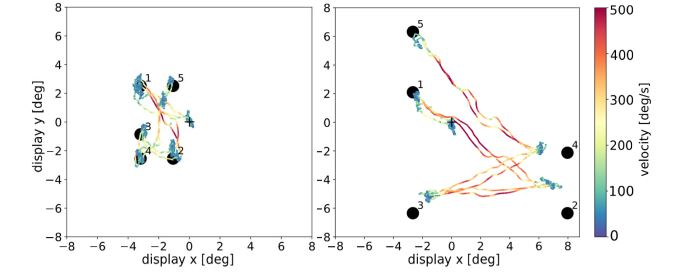

In [8]:
from IPython.display import Image
Image(filename='images/scanpaths.jpg')

## Apply the Data Augmentation/Enhancement
* Here you should implement your own data augmentation/enhancement
* implement the function 'transform(X_train,Y_train,Y_columns)' in 'DataAugmentation/data_augmentation.py'

In [9]:
from DataAugmentation import data_augmentation
X_train_augmented,Y_train_augmented = data_augmentation.transform(X_train,Y_train,Y_columns)

## Train model and get embeddings

In [10]:
embeddings_concatenated_augmented = evaluation.evaluate_create_test_embeddings(X_train_augmented,
                                                                               Y_train_augmented,
                                                                               X_test,Y_test,
                                                                               Y_columns,
                                                                               batch_size = batch_size)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fast_input (InputLayer)         [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
slow_input (InputLayer)         [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
slow_velocity_diff_input (Input [(None, 1000, 2)]    0                                            
__________________________________________________________________________________________________
fast_transform (TransformationL (None, 1000, 4)      0           fast_input[0][0]                 
____________________________________________________________________________________________

Epoch 1/100
338/338 [==============================] - 26s 54ms/step - loss: 2.1561 - accuracy: 0.3244 - val_loss: 1.8329 - val_accuracy: 0.4644
Epoch 2/100
338/338 [==============================] - 17s 51ms/step - loss: 0.9057 - accuracy: 0.6924 - val_loss: 0.9732 - val_accuracy: 0.6994
Epoch 3/100
338/338 [==============================] - 16s 46ms/step - loss: 0.5223 - accuracy: 0.8291 - val_loss: 0.6386 - val_accuracy: 0.7993
Epoch 4/100
338/338 [==============================] - 17s 51ms/step - loss: 0.3815 - accuracy: 0.8786 - val_loss: 0.5282 - val_accuracy: 0.8378
Epoch 5/100
338/338 [==============================] - 17s 51ms/step - loss: 0.2853 - accuracy: 0.9086 - val_loss: 0.4184 - val_accuracy: 0.8763
Epoch 6/100
338/338 [==============================] - 18s 52ms/step - loss: 0.2078 - accuracy: 0.9335 - val_loss: 0.7200 - val_accuracy: 0.8110
Epoch 7/100
338/338 [==============================] - 16s 48ms/step - loss: 0.1721 - accuracy: 0.9436 - val_loss: 0.3169 - val_ac

338/338 [==============================] - 15s 45ms/step - loss: 0.2084 - accuracy: 0.9318 - val_loss: 0.5582 - val_accuracy: 0.8461
Epoch 8/100
338/338 [==============================] - 17s 49ms/step - loss: 0.1562 - accuracy: 0.9493 - val_loss: 0.3577 - val_accuracy: 0.8918
Epoch 9/100
338/338 [==============================] - 15s 45ms/step - loss: 0.1540 - accuracy: 0.9486 - val_loss: 0.3108 - val_accuracy: 0.9035
Epoch 10/100
338/338 [==============================] - 15s 45ms/step - loss: 0.1132 - accuracy: 0.9632 - val_loss: 0.3930 - val_accuracy: 0.8874
Epoch 11/100
338/338 [==============================] - 16s 49ms/step - loss: 0.1066 - accuracy: 0.9657 - val_loss: 0.2929 - val_accuracy: 0.9181
Epoch 12/100
338/338 [==============================] - 15s 45ms/step - loss: 0.0974 - accuracy: 0.9687 - val_loss: 0.2963 - val_accuracy: 0.9090
Epoch 13/100
338/338 [==============================] - 16s 49ms/step - loss: 0.0885 - accuracy: 0.9727 - val_loss: 0.3640 - val_accuracy: 

In [11]:
embeddings_concatenated_baseline = evaluation.evaluate_create_test_embeddings(X_train,
                                                                              Y_train,
                                                                              X_test,
                                                                              Y_test,
                                                                              Y_columns,
                                                                              batch_size = batch_size)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fast_input (InputLayer)         [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
slow_input (InputLayer)         [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
slow_velocity_diff_input (Input [(None, 1000, 2)]    0                                            
__________________________________________________________________________________________________
fast_transform (TransformationL (None, 1000, 4)      0           fast_input[0][0]                 
____________________________________________________________________________________________

Epoch 1/100
1688/1688 [==============================] - 92s 52ms/step - loss: 3.5469 - accuracy: 0.1301 - val_loss: 2.6016 - val_accuracy: 0.3104
Epoch 2/100
1688/1688 [==============================] - 85s 51ms/step - loss: 1.9487 - accuracy: 0.4425 - val_loss: 1.5815 - val_accuracy: 0.5548
Epoch 3/100
1688/1688 [==============================] - 86s 51ms/step - loss: 1.1823 - accuracy: 0.6519 - val_loss: 1.0358 - val_accuracy: 0.6924
Epoch 4/100
1688/1688 [==============================] - 84s 50ms/step - loss: 0.8689 - accuracy: 0.7403 - val_loss: 0.8024 - val_accuracy: 0.7591
Epoch 5/100
1688/1688 [==============================] - 84s 50ms/step - loss: 0.6950 - accuracy: 0.7877 - val_loss: 0.7070 - val_accuracy: 0.7867
Epoch 6/100
1688/1688 [==============================] - 86s 51ms/step - loss: 0.5907 - accuracy: 0.8193 - val_loss: 0.6402 - val_accuracy: 0.8081
Epoch 7/100
1688/1688 [==============================] - 90s 53ms/step - loss: 0.5058 - accuracy: 0.8432 - val_loss: 0

1688/1688 [==============================] - 88s 52ms/step - loss: 0.0832 - accuracy: 0.9726 - val_loss: 0.4312 - val_accuracy: 0.8932
Epoch 21/100
1688/1688 [==============================] - 89s 53ms/step - loss: 0.0815 - accuracy: 0.9731 - val_loss: 0.5034 - val_accuracy: 0.8793
Epoch 22/100
1688/1688 [==============================] - 90s 54ms/step - loss: 0.0760 - accuracy: 0.9745 - val_loss: 0.5360 - val_accuracy: 0.8782
Epoch 23/100
1688/1688 [==============================] - 91s 54ms/step - loss: 0.0719 - accuracy: 0.9756 - val_loss: 0.5214 - val_accuracy: 0.8796
Epoch 24/100
1688/1688 [==============================] - 90s 53ms/step - loss: 0.0683 - accuracy: 0.9780 - val_loss: 0.5376 - val_accuracy: 0.8716
Epoch 25/100
1688/1688 [==============================] - 90s 53ms/step - loss: 0.0670 - accuracy: 0.9783 - val_loss: 0.4660 - val_accuracy: 0.8937
Epoch 26/100
1688/1688 [==============================] - 91s 54ms/step - loss: 0.0600 - accuracy: 0.9797 - val_loss: 0.5604 

In [12]:
num_sessions = len(np.unique(Y_test[:,Y_columns['session']]))
print('number of sessions: ' + str(num_sessions))

number of sessions: 4


## Plot results

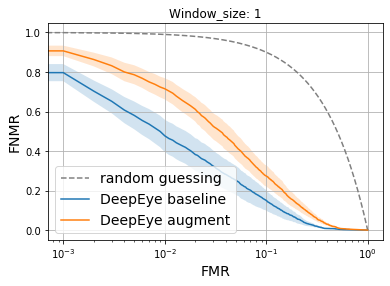

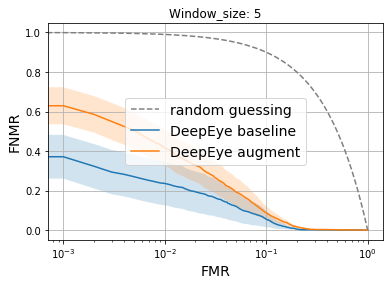

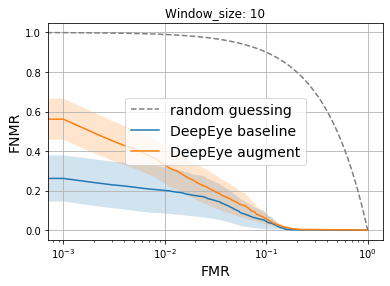

In [13]:
window_sizes = [1,5,10]
n_train_users = 0
n_enrolled_users = 1
n_impostors = 24
n_enrollment_sessions = num_sessions -1
n_test_sessions = 1
test_user = None
test_sessions = None
user_test_sessions = None 
enrollment_sessions = None
verbose = 0
random_state = 42,
seconds_per_session = None
model_names = ['DeepEye baseline',
              'DeepEye augment']
embedding_list = [embeddings_concatenated_baseline,embeddings_concatenated_augmented]
metric_lists = []
for i in range(len(model_names)):
    metric_dict = dict()
    for random_state in tqdm(np.arange(10)):
        from sklearn import metrics
        (score_dicts, label_dicts) = evaluation.get_scores_and_labels_from_raw(
                                    test_embeddings=embedding_list[i],
                                    Y_test=Y_test,
                                    Y_columns=Y_columns,
                                    window_sizes=window_sizes,
                                    n_train_users = n_train_users,
                                    n_enrolled_users = n_enrolled_users,
                                    n_impostors = n_impostors,
                                    n_enrollment_sessions = n_enrollment_sessions,
                                    n_test_sessions = n_test_sessions,
                                    test_user = test_user,
                                    test_sessions = test_sessions,
                                    user_test_sessions = user_test_sessions,
                                    enrollment_sessions = enrollment_sessions,
                                    verbose = verbose,
                                    random_state = random_state,
                                    seconds_per_session = seconds_per_session)

        for window_size in window_sizes:
            window_size = str(window_size)
            cur_scores = score_dicts[window_size]
            cur_label  = label_dicts[window_size]
            fpr, tpr, thresholds = metrics.roc_curve(cur_label, cur_scores, pos_label=1)
            if window_size not in metric_dict:
                metric_dict[window_size] = dict()
            if 'fpr' not in  metric_dict[window_size]:
                metric_dict[window_size]['fpr'] = []
                metric_dict[window_size]['tpr'] = []
            metric_dict[window_size]['fpr'].append(fpr)
            metric_dict[window_size]['tpr'].append(tpr)
    metric_lists.append(metric_dict)


for window_size in window_sizes:
    for i in range(len(model_names)):
        metric_dict = metric_lists[i]
        model_name = model_names[i]
        if i == 0:
            plot_random = True
        else:
            plot_random = False
        window_size = str(window_size)
        evaluation.avg_fnr_fpr_curve(metric_dict[window_size]['fpr'], metric_dict[window_size]['tpr'], 
                label = model_name, plot_random=plot_random,
                title = 'Window_size: ' + window_size, plot_statistics = False,
                loc = 'best', plot_legend = True,
                plot_points = 1000, ncol=1,
                bbox_to_anchor=None,
                starting_point = None,
                fontsize = 14, xscale = 'log',
                setting = 'verification')
    plt.show()

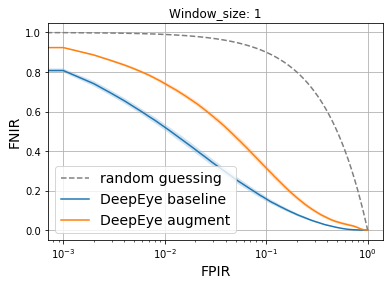

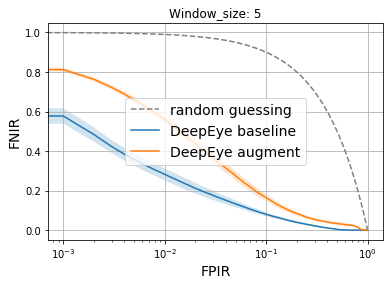

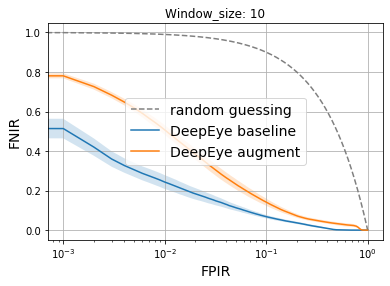

In [14]:
window_sizes = [1,5,10]
n_train_users = 0
n_enrolled_users = 20
n_impostors = 5
n_enrollment_sessions = num_sessions -1
n_test_sessions = 1
test_user = None
test_sessions = None
user_test_sessions = None 
enrollment_sessions = None
verbose = 0
random_state = 42,
seconds_per_session = None
model_names = ['DeepEye baseline',
              'DeepEye augment']
embedding_list = [embeddings_concatenated_baseline,embeddings_concatenated_augmented]
metric_lists = []
for i in range(len(model_names)):
    metric_dict = dict()
    for random_state in tqdm(np.arange(10)):
        from sklearn import metrics
        (score_dicts, label_dicts) = evaluation.get_scores_and_labels_from_raw(
                                    test_embeddings=embedding_list[i],
                                    Y_test=Y_test,
                                    Y_columns=Y_columns,
                                    window_sizes=window_sizes,
                                    n_train_users = n_train_users,
                                    n_enrolled_users = n_enrolled_users,
                                    n_impostors = n_impostors,
                                    n_enrollment_sessions = n_enrollment_sessions,
                                    n_test_sessions = n_test_sessions,
                                    test_user = test_user,
                                    test_sessions = test_sessions,
                                    user_test_sessions = user_test_sessions,
                                    enrollment_sessions = enrollment_sessions,
                                    verbose = verbose,
                                    random_state = random_state,
                                    seconds_per_session = seconds_per_session)

        for window_size in window_sizes:
            window_size = str(window_size)
            cur_scores = score_dicts[window_size]
            cur_label  = label_dicts[window_size]
            fpr, tpr, thresholds = metrics.roc_curve(cur_label, cur_scores, pos_label=1)
            if window_size not in metric_dict:
                metric_dict[window_size] = dict()
            if 'fpr' not in  metric_dict[window_size]:
                metric_dict[window_size]['fpr'] = []
                metric_dict[window_size]['tpr'] = []
            metric_dict[window_size]['fpr'].append(fpr)
            metric_dict[window_size]['tpr'].append(tpr)
    metric_lists.append(metric_dict)


for window_size in window_sizes:
    for i in range(len(model_names)):
        metric_dict = metric_lists[i]
        model_name = model_names[i]
        if i == 0:
            plot_random = True
        else:
            plot_random = False
        window_size = str(window_size)
        evaluation.avg_fnr_fpr_curve(metric_dict[window_size]['fpr'], metric_dict[window_size]['tpr'], 
                label = model_name, plot_random=plot_random,
                title = 'Window_size: ' + window_size, plot_statistics = False,
                loc = 'best', plot_legend = True,
                plot_points = 1000, ncol=1,
                bbox_to_anchor=None,
                starting_point = None,
                fontsize = 14, xscale = 'log',
                setting = 'identification')
    plt.show()